## Recreate Figure 5 from Still et al. (2022)

For all the detail involved in their energy balance model, the authors of this paper only show data from the energy balance approach in Figure 5. This notebook describes how we can reproduce this figure in Cropbox. The figure and caption in question are shown below:

<div style="width: 25%">
<img src="https://www.pnas.org/cms/10.1073/pnas.2205682119/asset/c1f4c47f-b43e-4c51-bdd4-06e804390d1f/assets/images/large/pnas.2205682119fig05.jpg"/>
<i>Modeled Tleaf − Tair (black solid line), leaf heating from Rnet (W m−2, red dotted line), and leaf cooling from transpiration (blue dashed line) at BCI (in °C) shown in (A). A typical example of a 6-d summer period for modeled Tleaf versus measured Tair (both °C) at Metolius (B) and BCI (C) for representative rain-free periods (May 25–June 1, 2015 and June 12–18, 2015, respectively). Color shading is by hour of day.</i>
</div>

The data used to produce this figure is [available from Zenodo](https://zenodo.org/records/6862565) as `.Rdata` files. I downloaded these, converted to CSV, and uploaded to the `data` directory for convenience.

### Setup

In [1]:
if occursin("notebooks", pwd())
    cd("..") 
end

println(pwd())

using Cropbox
using Unitful
using CSV
using DataFrames
using Dates
using TimeZones
using Plots

include("leaf_eb_still.jl")

G:\Other computers\My Laptop\UW\Classes\SEFS508\Project


WebIO._IJuliaInit()

LeafTemperature_Still

### Read in data

In [2]:
BCI = CSV.read("data/BCI.csv", DataFrame) |> unitfy
MR = CSV.read("data/MR.csv", DataFrame) |> unitfy

Row,date,GPP,Tair,RH,Pressure,wind_speed,SWdn,SWup,LWdn,LWup
,DateTime,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,2015-04-16T00:15:00,2.872 μmol m^-2 s^-1,276.31 K,0.6254,87.93 kPa,1.99 m s^-1,0.0 W m^-2,0.0 W m^-2,226.77 W m^-2,306.7 W m^-2
2,2015-04-16T00:45:00,2.853 μmol m^-2 s^-1,276.21 K,0.6282,87.92 kPa,2.05 m s^-1,0.0 W m^-2,0.0 W m^-2,227.5 W m^-2,307.37 W m^-2
3,2015-04-16T01:15:00,2.835 μmol m^-2 s^-1,275.98 K,0.636,87.9 kPa,1.48 m s^-1,0.0 W m^-2,0.0 W m^-2,224.43 W m^-2,304.3 W m^-2
4,2015-04-16T01:45:00,2.816 μmol m^-2 s^-1,275.86 K,0.6446,87.88 kPa,1.39 m s^-1,0.0 W m^-2,0.0 W m^-2,225.17 W m^-2,304.4 W m^-2
5,2015-04-16T02:15:00,2.797 μmol m^-2 s^-1,275.66 K,0.6573,87.87 kPa,0.83 m s^-1,0.0 W m^-2,0.0 W m^-2,226.17 W m^-2,305.3 W m^-2
6,2015-04-16T02:45:00,2.778 μmol m^-2 s^-1,275.66 K,0.6568,87.87 kPa,1.2 m s^-1,0.0 W m^-2,0.0 W m^-2,226.3 W m^-2,305.13 W m^-2
7,2015-04-16T03:15:00,2.76 μmol m^-2 s^-1,275.8 K,0.6479,87.87 kPa,1.66 m s^-1,0.0 W m^-2,0.0 W m^-2,226.23 W m^-2,304.33 W m^-2
8,2015-04-16T03:45:00,2.743 μmol m^-2 s^-1,275.63 K,0.6459,87.86 kPa,1.3 m s^-1,0.0 W m^-2,0.0 W m^-2,225.57 W m^-2,303.73 W m^-2
9,2015-04-16T04:15:00,2.727 μmol m^-2 s^-1,275.63 K,0.643,87.85 kPa,0.36 m s^-1,0.0 W m^-2,0.0 W m^-2,225.6 W m^-2,304.07 W m^-2


### Data cleaning

In [3]:
# GPP sign needs to be flipped, but only in MR.
MR.GPP = -MR.GPP

# Data in the figure are limited to observations between 0600-2000 and dates indicated in the caption
# https://discourse.julialang.org/t/how-to-filter-a-dataframe-of-datetime-data-by-the-time-of-day/79958
BCI_start = DateTime(2015, 6, 12)
BCI_end   = DateTime(2015, 6, 18, 23)
MR_start  = DateTime(2015, 5, 25)
MR_end    = DateTime(2015, 6, 1, 23)

BCI_filter = filter(row -> (BCI_start < row.date < BCI_end) && (6 <= hour(row.date) <= 20), BCI)
MR_filter = filter(row -> (MR_start < row.date < MR_end) && (6 <= hour(row.date) <= 20), MR)

# The actual datetimes have gaps and cropbox will error out on these. Make a fake index to get it to simulate.
# This is very hacky lol.
init_time = Date(2000, 1, 1)
BCI_filter[!, "index_date"] = collect(init_time:Day(1):init_time+Day(nrow(BCI_filter)-1))
MR_filter[!, "index_date"] = collect(init_time:Day(1):init_time+Day(nrow(MR_filter)-1))

240-element Vector{Date}:
 2000-01-01
 2000-01-02
 2000-01-03
 2000-01-04
 2000-01-05
 2000-01-06
 2000-01-07
 2000-01-08
 2000-01-09
 2000-01-10
 2000-01-11
 2000-01-12
 2000-01-13
 ⋮
 2000-08-16
 2000-08-17
 2000-08-18
 2000-08-19
 2000-08-20
 2000-08-21
 2000-08-22
 2000-08-23
 2000-08-24
 2000-08-25
 2000-08-26
 2000-08-27

### Define systems and configs

In [4]:
@system LeafTemperatureMR(LeafTemperature_Still, LatentHeat, NeedleleafConductance, Air, Controller) begin
    calendar(context)             ~      ::Calendar
    t(calendar.date): date        ~ track::date

    data                          ~ provide(parameter, index = :index_date, init = t)
    # Explicitly link parameters to the data.
    Ta: air_temperature ~ drive(from = data, by = :Tair, u"K")
    Pa: air_pressure ~ drive(from=data, by = :Pressure, u"kPa")
    RH: relative_humidity ~ drive(from=data, by=:RH)
    u: wind_speed ~ drive(from=data, by=:wind_speed, u"m/s")
    A: net_photosynthesis ~ drive(from=data, by=:GPP, u"μmol / m^2 / s")
    SW_in: shortwave_downwelling ~ drive(from=data, by=:SWdn, u"W / m^2")
    SW_out: shortwave_upwelling ~ drive(from=data, by=:SWup, u"W / m^2")
    LW_in: longwave_downwelling ~ drive(from=data, by=:LWdn, u"W / m^2")
    
    # These are same as the defaults, but just to be explicit
    d: characteristic_dimension => 0.01 ~ preserve(parameter, u"m")
    g0: intercept => 0 ~ preserve(parameter, u"mmol / m^2 / s")
    g1: slope => 2.35 ~ preserve(parameter, u"kPa^0.5")
end

@system LeafTemperatureBCI(LeafTemperature_Still, LatentHeat, BroadleafConductance, Air, Controller) begin
    calendar(context)             ~      ::Calendar
    t(calendar.date): date        ~ track::date

    data                          ~ provide(parameter, index = :index_date, init = t)
    # Link parameters to the data.
    Ta: air_temperature ~ drive(from = data, by = :Tair, u"K")
    # Air pressure isn't provided, assume a reasonable constant value
    Pa: air_pressure => 100 ~ preserve(parameter, u"kPa")
    RH: relative_humidity ~ drive(from=data, by=:RH)
    u: wind_speed ~ drive(from=data, by=:wind_speed, u"m/s")
    A: net_photosynthesis ~ drive(from=data, by=:GPP, u"μmol / m^2 / s")
    SW_in: shortwave_downwelling ~ drive(from=data, by=:SWdn, u"W / m^2")
    # Upwelling shortwave isn't provided, but SW_in has negative values, so I assume
    # it is actually net shortwave. In this case setting SW_out = 0 is reasonable.
    SW_out: shortwave_upwelling => 0 ~ preserve(parameter, u"W / m^2")
    # Values for downwelling longwave do not make sense, so I guess it must really
    # be net longwave?
    LW_net: longwave_flux ~ drive(from=data, by=:LWdn, u"W / m^2")
    
    # Redefine constants for broadleaf conductance
    d: characteristic_dimension => 0.1 ~ preserve(parameter, u"m")
    g0: intercept => 0 ~ preserve(parameter, u"mmol / m^2 / s")
    g1: slope => 3.77 ~ preserve(parameter, u"kPa^0.5")
end

LeafTemperatureBCI

In [5]:
mr_config = @config (
    Calendar => (;
        init = ZonedDateTime(minimum(MR_filter.index_date), tz"UTC"),
        last = ZonedDateTime(maximum(MR_filter.index_date), tz"UTC"),
    ),
    Clock => (;
        step = 1u"d",
    ),
    LeafTemperatureMR => (;
        data = MR_filter,
    ),
)

bci_config = @config (
    Calendar => (;
        init = ZonedDateTime(minimum(BCI_filter.index_date), tz"UTC"),
        last = ZonedDateTime(maximum(BCI_filter.index_date), tz"UTC"),
    ),
    Clock => (;
        step = 1u"d",
    ),
    LeafTemperatureBCI => (;
        data = BCI_filter,
    ),
)

init,=,"ZonedDateTime(2000, 1, 1, tz""UTC"")"
last,=,"ZonedDateTime(2000, 7, 28, tz""UTC"")"
step,=,24 hr
data,=,210×8 DataFrame…


### Run simulation

In [6]:
MR_sim_result = simulate(LeafTemperatureMR;
    config = mr_config,
    stop = "calendar.stop",
    target = [:dT_LE, :dT_Rn, :dT, :T_leaf, :LE, :gs, :A],
    verbose = true
)

BCI_sim_result = simulate(LeafTemperatureBCI;
    config = bci_config,
    stop = "calendar.stop",
    target = [:dT_LE, :dT_Rn, :dT, :T_leaf, :LE, :gs, :A, :Rn, :SW_net],
    verbose = true
)

Iterations: 239    Time: 0:00:01 ( 7.19 ms/it)


Row,time,dT_LE,dT_Rn,dT,T_leaf,LE,gs,A,Rn,SW_net
,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 hr,-2.13622 K,3.64422 K,1.508 K,301.993 K,195.798 W m^-2,662.6 mmol m^-2 s^-1,26.5663 μmol m^-2 s^-1,334.017 W m^-2,379.095 W m^-2
2,24.0 hr,-2.18441 K,3.55093 K,1.36652 K,302.442 K,205.191 W m^-2,628.622 mmol m^-2 s^-1,28.3193 μmol m^-2 s^-1,333.554 W m^-2,385.735 W m^-2
3,48.0 hr,-2.13224 K,4.03265 K,1.90041 K,303.331 K,229.41 W m^-2,526.936 mmol m^-2 s^-1,24.4503 μmol m^-2 s^-1,433.878 W m^-2,485.286 W m^-2
4,72.0 hr,-2.55833 K,4.37131 K,1.81299 K,303.729 K,250.643 W m^-2,575.61 mmol m^-2 s^-1,27.9076 μmol m^-2 s^-1,428.264 W m^-2,476.071 W m^-2
5,96.0 hr,-1.78008 K,2.78072 K,1.00064 K,302.727 K,190.769 W m^-2,523.673 mmol m^-2 s^-1,26.0375 μmol m^-2 s^-1,298.005 W m^-2,349.882 W m^-2
6,120.0 hr,-1.97664 K,3.2511 K,1.27446 K,302.94 K,213.108 W m^-2,580.935 mmol m^-2 s^-1,27.7388 μmol m^-2 s^-1,350.511 W m^-2,393.489 W m^-2
7,144.0 hr,-2.86712 K,4.43664 K,1.56953 K,303.888 K,295.274 W m^-2,724.761 mmol m^-2 s^-1,36.368 μmol m^-2 s^-1,456.913 W m^-2,509.245 W m^-2
8,168.0 hr,-1.99178 K,3.20762 K,1.21584 K,303.346 K,214.046 W m^-2,533.805 mmol m^-2 s^-1,26.9168 μmol m^-2 s^-1,344.707 W m^-2,397.467 W m^-2
9,192.0 hr,-2.03341 K,3.44086 K,1.40745 K,303.813 K,232.15 W m^-2,501.882 mmol m^-2 s^-1,26.1764 μmol m^-2 s^-1,392.835 W m^-2,446.17 W m^-2


In [7]:
# Now just mash the two dataframes back together. Also drop NaNs since this breaks plotting.
MR_combined = hcat(MR_filter, MR_sim_result)
MR_nonan = filter(row -> !isnan(row.T_leaf), MR_combined)

BCI_combined = hcat(BCI_filter, BCI_sim_result)
BCI_nonan = filter(row -> !isnan(row.T_leaf), BCI_combined)

Row,date,Tair,wind_speed,SWdn,LWdn,RH,GPP,index_date,time,dT_LE,dT_Rn,dT,T_leaf,LE,gs,A,Rn,SW_net
,DateTime,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Date,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,2015-06-12T10:00:00,300.485 K,2.04846 m s^-1,758.19 W m^-2,-45.0783 W m^-2,0.857377,26.5663 μmol m^-2 s^-1,2000-01-01,0.0 hr,-2.13622 K,3.64422 K,1.508 K,301.993 K,195.798 W m^-2,662.6 mmol m^-2 s^-1,26.5663 μmol m^-2 s^-1,334.017 W m^-2,379.095 W m^-2
2,2015-06-12T10:30:00,301.075 K,2.17211 m s^-1,771.471 W m^-2,-52.1817 W m^-2,0.81753,28.3193 μmol m^-2 s^-1,2000-01-02,24.0 hr,-2.18441 K,3.55093 K,1.36652 K,302.442 K,205.191 W m^-2,628.622 mmol m^-2 s^-1,28.3193 μmol m^-2 s^-1,333.554 W m^-2,385.735 W m^-2
3,2015-06-12T11:00:00,301.43 K,2.96223 m s^-1,970.573 W m^-2,-51.4083 W m^-2,0.807854,24.4503 μmol m^-2 s^-1,2000-01-03,48.0 hr,-2.13224 K,4.03265 K,1.90041 K,303.331 K,229.41 W m^-2,526.936 mmol m^-2 s^-1,24.4503 μmol m^-2 s^-1,433.878 W m^-2,485.286 W m^-2
4,2015-06-12T11:30:00,301.916 K,2.39947 m s^-1,952.141 W m^-2,-47.8067 W m^-2,0.791809,27.9076 μmol m^-2 s^-1,2000-01-04,72.0 hr,-2.55833 K,4.37131 K,1.81299 K,303.729 K,250.643 W m^-2,575.61 mmol m^-2 s^-1,27.9076 μmol m^-2 s^-1,428.264 W m^-2,476.071 W m^-2
5,2015-06-12T12:00:00,301.726 K,2.93958 m s^-1,699.764 W m^-2,-51.8767 W m^-2,0.775881,26.0375 μmol m^-2 s^-1,2000-01-05,96.0 hr,-1.78008 K,2.78072 K,1.00064 K,302.727 K,190.769 W m^-2,523.673 mmol m^-2 s^-1,26.0375 μmol m^-2 s^-1,298.005 W m^-2,349.882 W m^-2
6,2015-06-12T12:30:00,301.666 K,2.97889 m s^-1,786.978 W m^-2,-42.9783 W m^-2,0.79661,27.7388 μmol m^-2 s^-1,2000-01-06,120.0 hr,-1.97664 K,3.2511 K,1.27446 K,302.94 K,213.108 W m^-2,580.935 mmol m^-2 s^-1,27.7388 μmol m^-2 s^-1,350.511 W m^-2,393.489 W m^-2
7,2015-06-12T13:00:00,302.318 K,2.69263 m s^-1,1018.49 W m^-2,-52.3317 W m^-2,0.778401,36.368 μmol m^-2 s^-1,2000-01-07,144.0 hr,-2.86712 K,4.43664 K,1.56953 K,303.888 K,295.274 W m^-2,724.761 mmol m^-2 s^-1,36.368 μmol m^-2 s^-1,456.913 W m^-2,509.245 W m^-2
8,2015-06-12T13:30:00,302.13 K,2.96283 m s^-1,794.933 W m^-2,-52.76 W m^-2,0.773231,26.9168 μmol m^-2 s^-1,2000-01-08,168.0 hr,-1.99178 K,3.20762 K,1.21584 K,303.346 K,214.046 W m^-2,533.805 mmol m^-2 s^-1,26.9168 μmol m^-2 s^-1,344.707 W m^-2,397.467 W m^-2
9,2015-06-12T14:00:00,302.406 K,3.39866 m s^-1,892.34 W m^-2,-53.335 W m^-2,0.757011,26.1764 μmol m^-2 s^-1,2000-01-09,192.0 hr,-2.03341 K,3.44086 K,1.40745 K,303.813 K,232.15 W m^-2,501.882 mmol m^-2 s^-1,26.1764 μmol m^-2 s^-1,392.835 W m^-2,446.17 W m^-2


### Plotting time!

Figure 5a

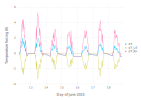

In [8]:
p = visualize(
    BCI_nonan, :date, [:dT, :dT_LE, :dT_Rn], 
    kind=:line,
    xlab="Day of June 2015",
    ylab="Temperature forcing"
)

Figure 5b

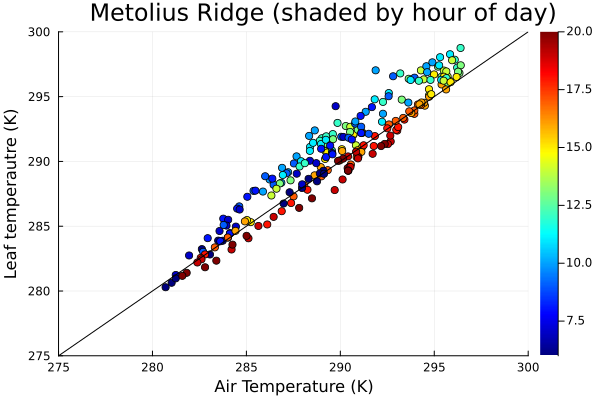

In [9]:
one_to_one = collect(250:1:350)

scatter(
    MR_nonan.Tair, MR_nonan.T_leaf, marker_z=hour.(MR_nonan.date), 
    color=:jet, legend=false, colorbar=true,
    plot_title="Metolius Ridge (shaded by hour of day)"
)
Plots.plot!(one_to_one, one_to_one, kind=:line, color="black")
xlabel!("Air Temperature (K)")
ylabel!("Leaf temperautre (K)")
xlims!((275, 300))
ylims!((275, 300))

Figure 5c

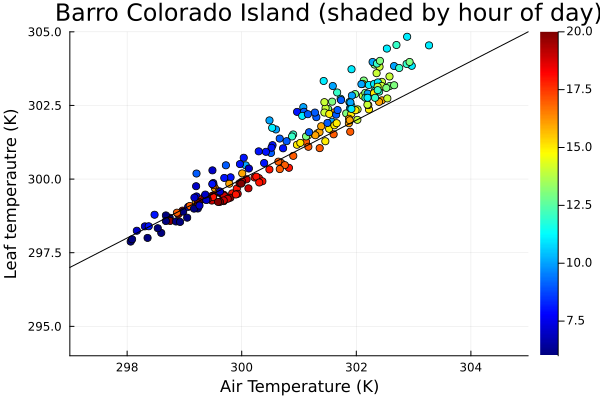

In [10]:
scatter(
    BCI_nonan.Tair, BCI_nonan.T_leaf, marker_z=hour.(BCI_nonan.date), 
    color=:jet, legend=false, colorbar=true,
    plot_title="Barro Colorado Island (shaded by hour of day)"
)
Plots.plot!(one_to_one, one_to_one, kind=:line, color="black")
xlabel!("Air Temperature (K)")
ylabel!("Leaf temperautre (K)")
xlims!((297, 305))
ylims!((294, 305))

In [12]:
parameters(LeafTemperatureBCI)

d,=,0.1 m
σ,=,5.67e-8 W K^-4 m^-2
α_LW,=,0.98
cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
data,=,nothing
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Pa,=,100 kPa
α_SW,=,0.5
